In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.max_columns", None)
pd.set_option("display.width", 120)

In [40]:
#Load the event log 
file_path = '/Users/ilianofasolino/Downloads/Business Information Systems/Exercises2026/EventLogs/dataset_for_exam.csv'
df_raw = pd.read_csv(file_path)
df_raw["time"] = pd.to_datetime(df_raw["time"])

print(f"Total events (raw): {df_raw.shape[0]}")
print(f"Total cases (raw):   {df_raw['stay_id'].nunique()}")

df_raw.head()

Total events (raw): 25115
Total cases (raw):   1820


,stay_id,time,activity,gender,race,arrival_transport,disposition,diagnosis_sequence,diagnosis_code,diagnosis_description,temperature,heartrate,resprate,o2sat,sbp,dbp,pain,acuity,chiefcomplaint,rhythm,drug_name,generic_drug_code,national_drug_code,reconciliation_nurse_id,drug_class_code,drug_class_classification,administering_nurse_id
0,30005370,2110-06-25 05:10:00,Enter the ED,F,WHITE,AMBULANCE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,30005370,2110-06-25 05:10:01,Triage in the ED,NaN,NaN,NaN,NaN,NaN,NaN,NaN,98.0,90.0,15.0,95.0,130.0,58.0,4,3.0,SBO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,30005370,2110-06-25 05:28:00,Medicine reconciliation,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ondansetron HCl [Zofran],16392.0,1.659005e+10,1.0,457.0,Antiemetic - Selective Serotonin 5-HT3 Antagon...,NaN
3,30005370,2110-06-25 05:28:00,Medicine reconciliation,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,omeprazole [Prilosec],43137.0,1.671407e+10,1.0,445.0,Gastric Acid Secretion Reducing Agents - Proto...,NaN
4,30005370,2110-06-25 05:28:00,Medicine reconciliation,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,acetaminophen [Acetaminophen Extra Strength],4490.0,1.000301e+10,1.0,577.0,Analgesic or Antipyretic Non-Opioid,NaN


In [41]:
#Column selection

columns_to_keep = [
    # main process mining
    "stay_id",
    "time",
    "activity",
    # case-level attributes
    "gender",
    "race",
    "arrival_transport",
    "acuity",
    "chiefcomplaint",
    "disposition",
]

df = df_raw[columns_to_keep].copy()

print(f"Keeped columns: {len(columns_to_keep)}")
print(columns_to_keep)
print(f"Shape after selection: {df.shape}")
df.head()

Keeped columns: 9
['stay_id', 'time', 'activity', 'gender', 'race', 'arrival_transport', 'acuity', 'chiefcomplaint', 'disposition']
Shape after selection: (25115, 9)


,stay_id,time,activity,gender,race,arrival_transport,acuity,chiefcomplaint,disposition
0,30005370,2110-06-25 05:10:00,Enter the ED,F,WHITE,AMBULANCE,NaN,NaN,NaN
1,30005370,2110-06-25 05:10:01,Triage in the ED,NaN,NaN,NaN,3.0,SBO,NaN
2,30005370,2110-06-25 05:28:00,Medicine reconciliation,NaN,NaN,NaN,NaN,NaN,NaN
3,30005370,2110-06-25 05:28:00,Medicine reconciliation,NaN,NaN,NaN,NaN,NaN,NaN
4,30005370,2110-06-25 05:28:00,Medicine reconciliation,NaN,NaN,NaN,NaN,NaN,NaN


In [42]:
#Aggregation of simultaneous events

print("Events BEFORE aggregation:", df.shape[0])

agg_dict = {
    "gender": "first",
    "race": "first",
    "arrival_transport": "first",
    "acuity": "first",
    "chiefcomplaint": "first",
    "disposition": "first",
}

df = (
    df
    .groupby(["stay_id", "time", "activity"], as_index=False)
    .agg(agg_dict)
    .sort_values(["stay_id", "time"])
)

print("Events AFTER aggregation:", df.shape[0])

Events BEFORE aggregation: 25115
Events AFTER aggregation: 16826


In [43]:
#Missing values 

df = df.sort_values(["stay_id", "time"]).reset_index(drop=True)

case_level_attrs = [
    "gender",
    "race",
    "arrival_transport",
    "acuity",
    "chiefcomplaint",
    "disposition",
]

# forward fill for each patient
df[case_level_attrs] = df.groupby("stay_id")[case_level_attrs].ffill()
# backward fill in order to cover cases where the value appear later on
df[case_level_attrs] = df.groupby("stay_id")[case_level_attrs].bfill()

In [44]:
#Noise Filtering (with incomplete cases plus few events [less than 4])

# in order to "ensure order"
df = df.sort_values(["stay_id", "time"]).reset_index(drop=True)

# first and last activity per case
first_acts = df.groupby("stay_id").first()
last_acts  = df.groupby("stay_id").last()

valid_start = first_acts[first_acts["activity"] == "Enter the ED"].index
valid_end   = last_acts[last_acts["activity"] == "Discharge from the ED"].index
valid_cases = set(valid_start) & set(valid_end)

print(f"Total cases: {df['stay_id'].nunique()}")
print(f"Cases with correct start: {len(valid_start)}")
print(f"Cases with correct end:   {len(valid_end)}")
print(f"Cases with start+end ok:   {len(valid_cases)}")

df = df[df["stay_id"].isin(valid_cases)].copy()

# filtering cases with < 4 events
events_per_case = df.groupby("stay_id").size()
few_event_cases = events_per_case[events_per_case < 4].index

print(f"Cases with LESS THAN 4 events: {len(few_event_cases)}")

df = df[~df["stay_id"].isin(few_event_cases)].copy()

print(f"Cases after filtering: {df['stay_id'].nunique()}")
print(f"Events after filtering: {df.shape[0]}")

Total cases: 1820
Cases with correct start: 1820
Cases with correct end:   1820
Cases with start+end ok:   1820
Cases with LESS THAN 4 events: 49
Cases after filtering: 1771
Events after filtering: 16679


In [45]:
#Noise Filtering (case duration outliers part)

case_times = df.groupby("stay_id").agg(
    start_time=("time", "min"),
    end_time=("time", "max"),
)
case_times["duration_hours"] = (
    (case_times["end_time"] - case_times["start_time"])
    .dt.total_seconds() / 3600
)

print("Stats duration (hours):")
print(case_times["duration_hours"].describe())

# range (that we already declared in the all prepocessing part, look at the report)
min_hours = 0.5   # 30 mins
max_hours = 48.0  # 48 hours

short_cases = case_times[case_times["duration_hours"] < min_hours].index
long_cases  = case_times[case_times["duration_hours"] > max_hours].index

print(f"Cases < {min_hours} h: {len(short_cases)}")
print(f"Cases > {max_hours} h: {len(long_cases)}")

outlier_cases = set(short_cases) | set(long_cases)
df = df[~df["stay_id"].isin(outlier_cases)].copy()

print(f"Cases AFTER removing outliers: {df['stay_id'].nunique()}")
print(f"Events AFTER removing outliers: {df.shape[0]}")

Stats duration (hours):
count    1771.000000
mean        6.917944
std         7.118647
min         0.066667
25%         3.291667
50%         5.100000
75%         7.825000
max        84.416667
Name: duration_hours, dtype: float64
Cases < 0.5 h: 6
Cases > 48.0 h: 11
Cases AFTER removing outliers: 1754
Events AFTER removing outliers: 16376


**Performance analysis**
--------------------

In [46]:
#THROUGHPUT TIME (total duration fro each case)

# Calculate start and end time for each case
case_performance = df.groupby('stay_id').agg(
    start_time=('time', 'min'),
    end_time=('time', 'max'),
    n_events=('activity', 'count')
).reset_index()

# Conversion throughput time in hours
case_performance['throughput_time_hours'] = (
    (case_performance['end_time'] - case_performance['start_time'])
    .dt.total_seconds() / 3600
)

# Descriptive statistics
print("THROUGHPUT TIME\n")
print(case_performance['throughput_time_hours'].describe())

print(f"\nMean:    {case_performance['throughput_time_hours'].mean():.2f} hours")
print(f"Median:  {case_performance['throughput_time_hours'].median():.2f} hours")
print(f"Std Dev: {case_performance['throughput_time_hours'].std():.2f} hours")

case_performance.head()


THROUGHPUT TIME

count    1754.000000
mean        6.581565
std         5.420621
min         0.550000
25%         3.300000
50%         5.083333
75%         7.695833
max        46.633333
Name: throughput_time_hours, dtype: float64

Mean:    6.58 hours
Median:  5.08 hours
Std Dev: 5.42 hours


,stay_id,start_time,end_time,n_events,throughput_time_hours
0,30005370,2110-06-25 05:10:00,2110-06-25 09:42:00,10,4.533333
1,30011087,2110-09-06 02:51:00,2110-09-06 05:09:56,7,2.315556
2,30016618,2110-04-26 00:33:00,2110-04-26 06:18:00,8,5.750000
3,30022872,2110-09-01 02:50:00,2110-09-01 10:30:00,13,7.666667
4,30023012,2110-11-25 14:52:00,2110-11-25 20:38:00,6,5.766667


In [47]:
#TIME-TO-TRIAGE (Enter → Triage)

#Extract timestamps for "Enter the ED" and "Triage in the ED" for each case
enter_times = df[df['activity'] == 'Enter the ED'].set_index('stay_id')['time']
triage_times = df[df['activity'] == 'Triage in the ED'].set_index('stay_id')['time']

#Calculate time-to-triage
time_to_triage = pd.DataFrame({
    'enter_time': enter_times,
    'triage_time': triage_times
})

time_to_triage['time_to_triage_minutes'] = (
    (time_to_triage['triage_time'] - time_to_triage['enter_time'])
    .dt.total_seconds() / 60
)

#Stats
print("TIME-TO-TRIAGE (Enter → Triage)\n")
print(time_to_triage['time_to_triage_minutes'].describe())

print(f"\nMean:    {time_to_triage['time_to_triage_minutes'].mean():.2f} minutes")
print(f"Median:  {time_to_triage['time_to_triage_minutes'].median():.2f} minutes")
print(f"Std Dev: {time_to_triage['time_to_triage_minutes'].std():.2f} minutes")

#Percentiles
print("\nPercentiles:")
for p in [10, 25, 50, 75, 90, 95]:
    val = time_to_triage['time_to_triage_minutes'].quantile(p/100)
    print(f"  {p}%: {val:.2f} minutes")

# Anomalous cases (time-to-triage > 60 minutes)
slow_triage = time_to_triage[time_to_triage['time_to_triage_minutes'] > 60]
print(f"\nCases with time-to-triage > 60 minutes: {len(slow_triage)} ({len(slow_triage)/len(time_to_triage)*100:.1f}%)")


TIME-TO-TRIAGE (Enter → Triage)

count    1.754000e+03
mean     1.666667e-02
std      3.470436e-18
min      1.666667e-02
25%      1.666667e-02
50%      1.666667e-02
75%      1.666667e-02
max      1.666667e-02
Name: time_to_triage_minutes, dtype: float64

Mean:    0.02 minutes
Median:  0.02 minutes
Std Dev: 0.00 minutes

Percentiles:
  10%: 0.02 minutes
  25%: 0.02 minutes
  50%: 0.02 minutes
  75%: 0.02 minutes
  90%: 0.02 minutes
  95%: 0.02 minutes

Cases with time-to-triage > 60 minutes: 0 (0.0%)


In [48]:
#TIME-TO-DISCHARGE (from the last activity → Discharge)

#For each case, I have found the timestamp of the last activity BEFORE Discharge and the Discharge timestamp

discharge_analysis = []

for stay_id in df['stay_id'].unique():
    case_df = df[df['stay_id'] == stay_id].sort_values('time')
    
    # Find Discharge event
    discharge_row = case_df[case_df['activity'] == 'Discharge from the ED']
    if len(discharge_row) == 0:
        continue
    
    discharge_time = discharge_row.iloc[0]['time']
    
    # Find last activity before Discharge
    before_discharge = case_df[case_df['time'] < discharge_time]
    if len(before_discharge) == 0:
        continue
    
    last_activity_time = before_discharge.iloc[-1]['time']
    last_activity_name = before_discharge.iloc[-1]['activity']
    
    time_to_discharge_minutes = (discharge_time - last_activity_time).total_seconds() / 60
    
    discharge_analysis.append({
        'stay_id': stay_id,
        'last_activity': last_activity_name,
        'last_activity_time': last_activity_time,
        'discharge_time': discharge_time,
        'time_to_discharge_minutes': time_to_discharge_minutes
    })

time_to_discharge = pd.DataFrame(discharge_analysis)

# Statistics
print("TIME-TO-DISCHARGE (last activity → Discharge)\n")
print(time_to_discharge['time_to_discharge_minutes'].describe())

# Which activity most often precedes Discharge?
print("\nLast activity before Discharge:")
last_act_counts = time_to_discharge['last_activity'].value_counts()
for act, cnt in last_act_counts.items():
    print(f"  - {act}: {cnt} ({cnt/len(time_to_discharge)*100:.1f}%)")


TIME-TO-DISCHARGE (last activity → Discharge)

count    1754.000000
mean       48.254571
std        61.767018
min         0.766667
25%         9.000000
50%        31.000000
75%        61.320833
max       820.700000
Name: time_to_discharge_minutes, dtype: float64

Last activity before Discharge:
  - Vital sign check: 1387 (79.1%)
  - Medicine dispensations: 290 (16.5%)
  - Medicine reconciliation: 57 (3.2%)
  - Triage in the ED: 20 (1.1%)


In [49]:
#PROCESS VARIANTS - Identification 

#Create the variant (sequence of activities) for each case
def get_variant(stay_id):
    case_activities = df[df['stay_id'] == stay_id].sort_values('time')['activity'].tolist()
    return ' → '.join(case_activities)

case_variants = df.groupby('stay_id').first().reset_index()[['stay_id']]
case_variants['variant'] = case_variants['stay_id'].apply(get_variant)

#Counting frequencies of the variants
variant_counts = case_variants['variant'].value_counts().reset_index()
variant_counts.columns = ['variant', 'frequency']
variant_counts['percentage'] = (variant_counts['frequency'] / len(case_variants) * 100).round(2)

#Add cumulative percentage
variant_counts['cumulative_percentage'] = variant_counts['percentage'].cumsum()

print(f"PROCESS VARIANTS\n")
print(f"Total unique variants: {len(variant_counts)}")
print(f"Total cases: {len(case_variants)}\n")

#Show top 10 most frequent variants
print("Top 10 most frequent variants:\n")
for idx, row in variant_counts.head(10).iterrows():
    print(f"{idx+1}. [{row['frequency']} cases, {row['percentage']:.1f}%]")
    print(f"   {row['variant']}\n")

#How many variants cover 80% of cases? APPLYING PARETO PRINCIPLE 
variants_80 = variant_counts[variant_counts['cumulative_percentage'] <= 80]
print(f"Variants covering 80% of cases: {len(variants_80)}")
print(f"Variants covering 90% of cases: {len(variant_counts[variant_counts['cumulative_percentage'] <= 90])}")

variant_counts.head(10)


PROCESS VARIANTS

Total unique variants: 884
Total cases: 1754

Top 10 most frequent variants:

1. [75 cases, 4.3%]
   Enter the ED → Triage in the ED → Vital sign check → Discharge from the ED

2. [59 cases, 3.4%]
   Enter the ED → Triage in the ED → Vital sign check → Vital sign check → Discharge from the ED

3. [46 cases, 2.6%]
   Enter the ED → Triage in the ED → Medicine dispensations → Vital sign check → Discharge from the ED

4. [34 cases, 1.9%]
   Enter the ED → Triage in the ED → Medicine reconciliation → Vital sign check → Discharge from the ED

5. [32 cases, 1.8%]
   Enter the ED → Triage in the ED → Vital sign check → Medicine dispensations → Vital sign check → Discharge from the ED

6. [32 cases, 1.8%]
   Enter the ED → Triage in the ED → Vital sign check → Medicine reconciliation → Vital sign check → Discharge from the ED

7. [31 cases, 1.8%]
   Enter the ED → Triage in the ED → Vital sign check → Vital sign check → Vital sign check → Discharge from the ED

8. [23 cases, 

,variant,frequency,percentage,cumulative_percentage
0,Enter the ED → Triage in the ED → Vital sign c...,75,4.28,4.28
1,Enter the ED → Triage in the ED → Vital sign c...,59,3.36,7.64
2,Enter the ED → Triage in the ED → Medicine dis...,46,2.62,10.26
3,Enter the ED → Triage in the ED → Medicine rec...,34,1.94,12.20
4,Enter the ED → Triage in the ED → Vital sign c...,32,1.82,14.02
5,Enter the ED → Triage in the ED → Vital sign c...,32,1.82,15.84
6,Enter the ED → Triage in the ED → Vital sign c...,31,1.77,17.61
7,Enter the ED → Vital sign check → Triage in th...,23,1.31,18.92
8,Enter the ED → Triage in the ED → Medicine rec...,21,1.20,20.12
9,Enter the ED → Vital sign check → Triage in th...,20,1.14,21.26


VARIANT PERFORMANCE ANALYSIS

Top 10 variants by frequency:

                                                                                                                      variant  n_cases  mean_duration  median_duration  std_duration  min_duration  max_duration
                                                   Enter the ED → Triage in the ED → Vital sign check → Discharge from the ED       75       3.074022         2.533333      1.795083      0.616667      9.650000
                                Enter the ED → Triage in the ED → Vital sign check → Vital sign check → Discharge from the ED       59       4.530160         4.007222      2.219316      0.566667     12.266667
                          Enter the ED → Triage in the ED → Medicine dispensations → Vital sign check → Discharge from the ED       46       3.224275         3.183333      1.468966      0.833333      7.233333
                         Enter the ED → Triage in the ED → Medicine reconciliation → Vital sign check →

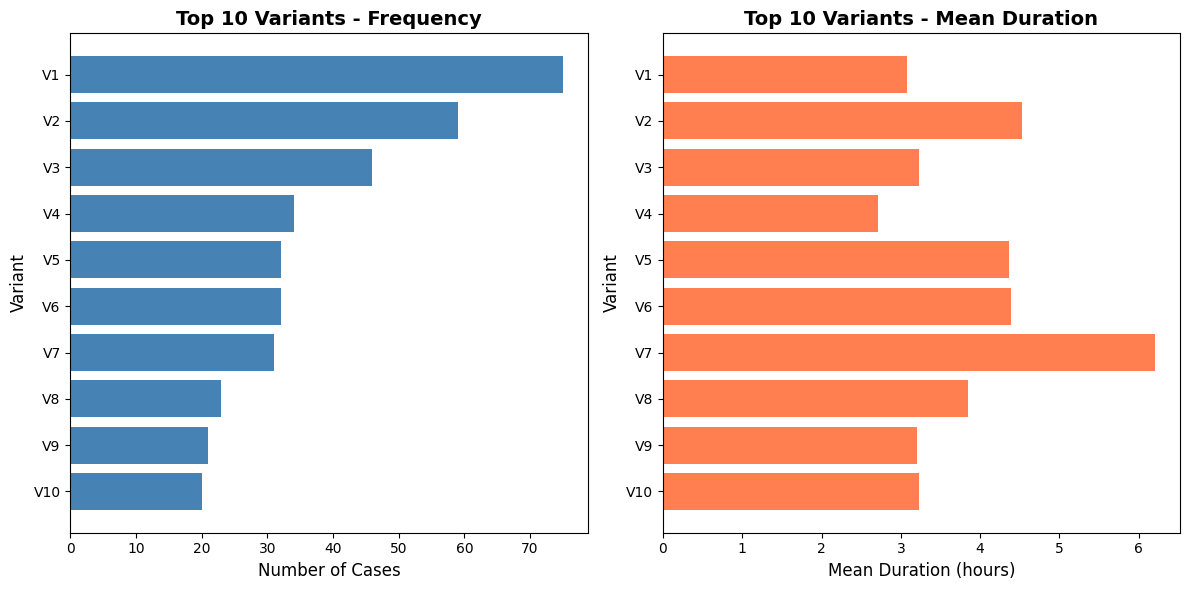

In [50]:
#ANALYZING DURATION BY VARIANT (and visualize it)

#Merge variants with case performance data
case_variants_perf = case_variants.merge(case_performance, on='stay_id')

#Calculate average duration for each variant
variant_performance = case_variants_perf.groupby('variant').agg(
    n_cases=('stay_id', 'count'),
    mean_duration=('throughput_time_hours', 'mean'),
    median_duration=('throughput_time_hours', 'median'),
    std_duration=('throughput_time_hours', 'std'),
    min_duration=('throughput_time_hours', 'min'),
    max_duration=('throughput_time_hours', 'max')
).reset_index()

#Sort by frequency
variant_performance = variant_performance.sort_values('n_cases', ascending=False)

print("VARIANT PERFORMANCE ANALYSIS\n") #MEMO: QUOTE THIS TO BE USED AS REFERENCE FOR THE CHARTS
print("Top 10 variants by frequency:\n")
print(variant_performance.head(10).to_string(index=False))

#Visualization 1: Top 10 variants - frequency
top_10_variants = variant_performance.head(10).copy()
top_10_variants['variant_label'] = [f"V{i+1}" for i in range(len(top_10_variants))]

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(top_10_variants['variant_label'], top_10_variants['n_cases'], color='steelblue')
plt.xlabel('Number of Cases', fontsize=12)
plt.ylabel('Variant', fontsize=12)
plt.title('Top 10 Variants - Frequency', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()

#Visualization 2: Top 10 variants - average duration
plt.subplot(1, 2, 2)
plt.barh(top_10_variants['variant_label'], top_10_variants['mean_duration'], color='coral')
plt.xlabel('Mean Duration (hours)', fontsize=12)
plt.ylabel('Variant', fontsize=12)
plt.title('Top 10 Variants - Mean Duration', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()


/var/folders/1f/q1fb9zx10z3c007d88nbt5100000gn/T/ipykernel_14626/2873185188.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=top_5_data, x='variant_label', y='throughput_time_hours', palette='Set2')


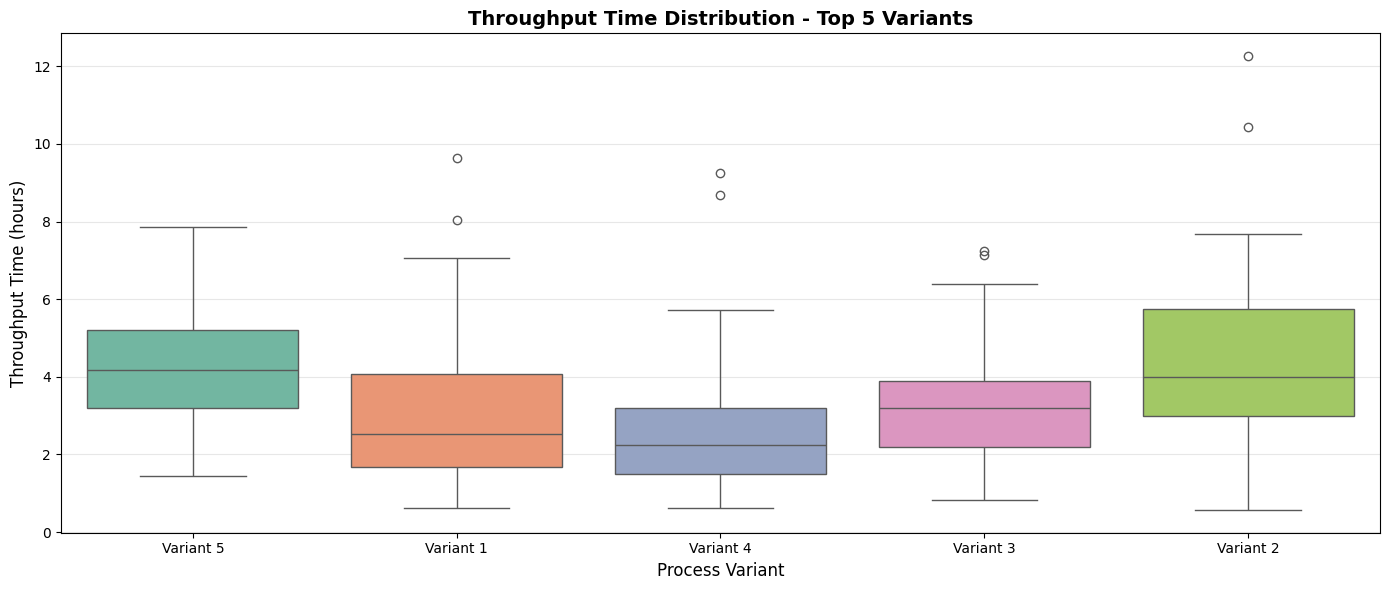

In [51]:
#BOXPLOT: DURATION DISTRIBUTION FOR TOP VARIANTS

#Get top 5 variants
top_5_variant_names = variant_performance.head(5)['variant'].tolist()

#Filter cases belonging to top 5 variants
top_5_data = case_variants_perf[case_variants_perf['variant'].isin(top_5_variant_names)].copy()

#Short Label
variant_labels_map = {var: f"Variant {i+1}" for i, var in enumerate(top_5_variant_names)}
top_5_data['variant_label'] = top_5_data['variant'].map(variant_labels_map)

#Boxplot
plt.figure(figsize=(14, 6))
sns.boxplot(data=top_5_data, x='variant_label', y='throughput_time_hours', palette='Set2')
plt.xlabel('Process Variant', fontsize=12)
plt.ylabel('Throughput Time (hours)', fontsize=12)
plt.title('Throughput Time Distribution - Top 5 Variants', fontsize=14, fontweight='bold')
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


/var/folders/1f/q1fb9zx10z3c007d88nbt5100000gn/T/ipykernel_14626/3657695685.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=perf_by_acuity, x='acuity', y='throughput_time_hours', palette='RdYlGn_r')


PERFORMANCE BY ACUITY LEVEL

Note: Acuity 1-3 = High urgency, 4-5 = Low urgency

 acuity  n_cases  mean_duration  median_duration  std_duration  min_duration  max_duration
      1      126       5.831272         4.575000      4.319652      0.707500     22.066667
      2      590       8.033486         6.100000      6.190183      0.566667     46.633333
      3      851       6.295248         4.933333      5.070371      0.550000     34.766667
      4      135       3.084691         2.900000      1.851045      0.616667     13.733333
      5        5       3.113333         1.466667      3.579793      0.733333      9.316667


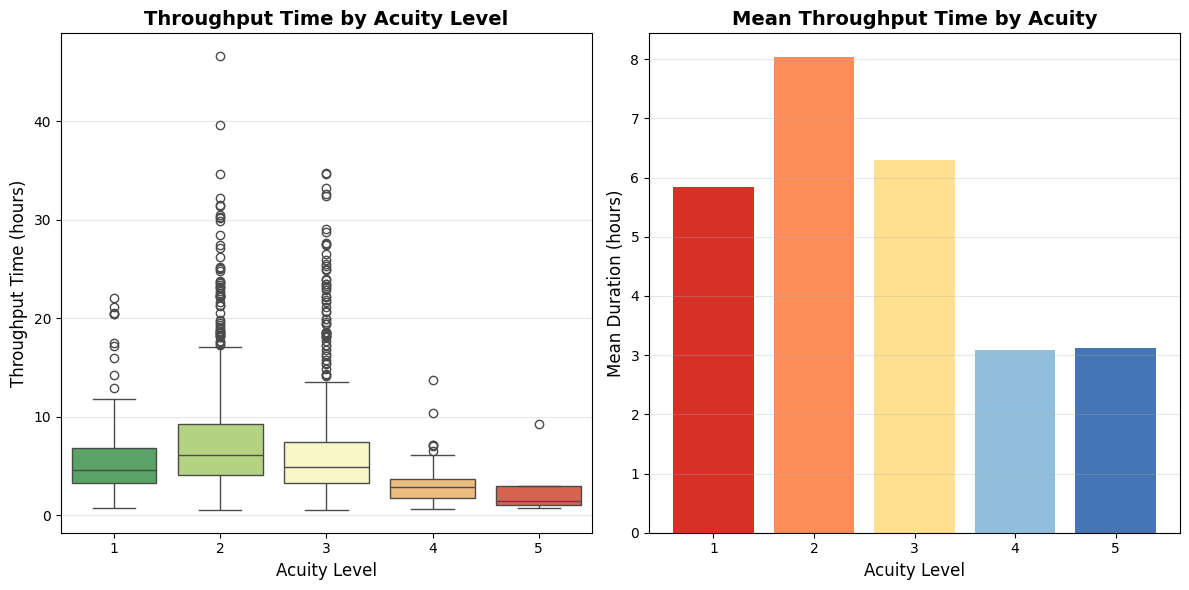


KEY INSIGHTS
Acuity 1 (Critical):    Mean = 5.83h
Acuity 2 (Urgent):      Mean = 8.03h
Acuity 3 (Less urgent): Mean = 6.30h


In [52]:
#PERFORMANCE ANALYSIS BY ACUITY LEVEL

#Get acuity for each case (take first occurrence per case)
case_acuity = df.groupby('stay_id')['acuity'].first().reset_index()

#Merge with performance data
perf_by_acuity = case_performance.merge(case_acuity, on='stay_id')

#Remove cases with missing acuity
perf_by_acuity = perf_by_acuity[perf_by_acuity['acuity'].notna()].copy()
perf_by_acuity['acuity'] = perf_by_acuity['acuity'].astype(int)

#Calculate statistics by acuity level
acuity_stats = perf_by_acuity.groupby('acuity').agg(
    n_cases=('stay_id', 'count'),
    mean_duration=('throughput_time_hours', 'mean'),
    median_duration=('throughput_time_hours', 'median'),
    std_duration=('throughput_time_hours', 'std'),
    min_duration=('throughput_time_hours', 'min'),
    max_duration=('throughput_time_hours', 'max')
).reset_index()

print("PERFORMANCE BY ACUITY LEVEL\n")
print("Note: Acuity 1-3 = High urgency, 4-5 = Low urgency\n")
print(acuity_stats.to_string(index=False))

#Boxplot by acuity
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.boxplot(data=perf_by_acuity, x='acuity', y='throughput_time_hours', palette='RdYlGn_r')
plt.xlabel('Acuity Level', fontsize=12)
plt.ylabel('Throughput Time (hours)', fontsize=12)
plt.title('Throughput Time by Acuity Level', fontsize=14, fontweight='bold')
plt.grid(axis='y', alpha=0.3)

#Bar chart: mean duration by acuity
plt.subplot(1, 2, 2)
plt.bar(acuity_stats['acuity'], acuity_stats['mean_duration'], 
        color=['#d73027', '#fc8d59', '#fee090', '#91bfdb', '#4575b4'])
plt.xlabel('Acuity Level', fontsize=12)
plt.ylabel('Mean Duration (hours)', fontsize=12)
plt.title('Mean Throughput Time by Acuity', fontsize=14, fontweight='bold')
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

#Statistical test
print("\nKEY INSIGHTS")
print(f"Acuity 1 (Critical):    Mean = {acuity_stats[acuity_stats['acuity']==1]['mean_duration'].values[0]:.2f}h")
print(f"Acuity 2 (Urgent):      Mean = {acuity_stats[acuity_stats['acuity']==2]['mean_duration'].values[0]:.2f}h")
print(f"Acuity 3 (Less urgent): Mean = {acuity_stats[acuity_stats['acuity']==3]['mean_duration'].values[0]:.2f}h")


BOTTLENECK ANALYSIS - Top 15 Slowest Transitions

                                      transition  n_occurrences  mean_duration  median_duration  std_duration  max_duration
        Triage in the ED → Discharge from the ED             20     138.106667       124.983333     77.667958    311.200000
             Vital sign check → Vital sign check           2159      93.348309        68.000000     88.898887    663.000000
       Triage in the ED → Medicine dispensations            345      74.189130        53.983333     71.414333    409.983333
      Medicine reconciliation → Vital sign check            624      72.730769        51.000000     74.577986    465.000000
      Triage in the ED → Medicine reconciliation            403      72.164475        53.983333     62.245138    495.983333
 Medicine reconciliation → Discharge from the ED             57      72.151754        47.000000     61.806236    237.000000
       Vital sign check → Medicine dispensations           1387      58.705840    

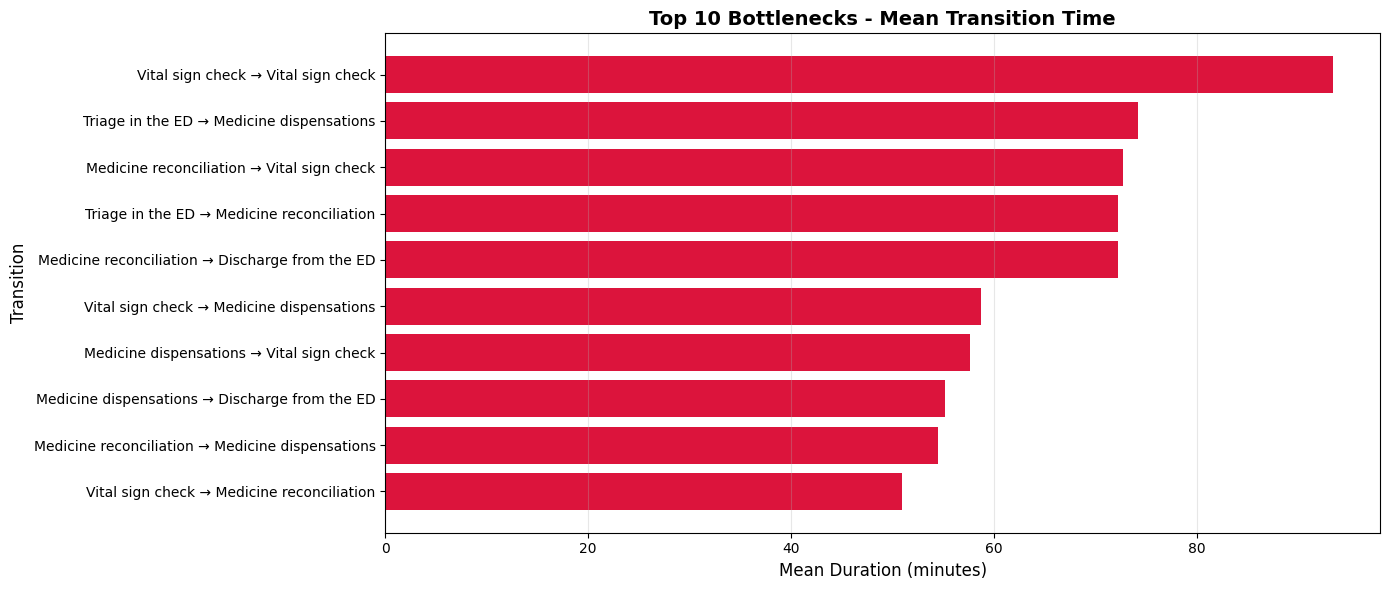

In [53]:
#BOTTLENECKS (transition times between activities)

#For each case, calculate time between consecutive activities
transition_times = []

for stay_id in df['stay_id'].unique():
    case_df = df[df['stay_id'] == stay_id].sort_values('time').reset_index(drop=True)
    
    for i in range(len(case_df) - 1):
        from_activity = case_df.loc[i, 'activity']
        to_activity = case_df.loc[i+1, 'activity']
        from_time = case_df.loc[i, 'time']
        to_time = case_df.loc[i+1, 'time']
        
        duration_minutes = (to_time - from_time).total_seconds() / 60
        
        transition_times.append({
            'stay_id': stay_id,
            'from_activity': from_activity,
            'to_activity': to_activity,
            'duration_minutes': duration_minutes
        })

transitions_df = pd.DataFrame(transition_times)

#Create transition label
transitions_df['transition'] = (
    transitions_df['from_activity'] + ' → ' + transitions_df['to_activity']
)

#Calculate statistics for each transition type
transition_stats = transitions_df.groupby('transition').agg(
    n_occurrences=('duration_minutes', 'count'),
    mean_duration=('duration_minutes', 'mean'),
    median_duration=('duration_minutes', 'median'),
    std_duration=('duration_minutes', 'std'),
    max_duration=('duration_minutes', 'max')
).reset_index()

#Sort by mean duration (descending) to find bottlenecks
transition_stats = transition_stats.sort_values('mean_duration', ascending=False)

print("BOTTLENECK ANALYSIS - Top 15 Slowest Transitions\n")
print(transition_stats.head(15).to_string(index=False))

#Filter only frequent transitions (>= 50 occurrences) for reliability
frequent_transitions = transition_stats[transition_stats['n_occurrences'] >= 50].copy()

print("\nFREQUENT TRANSITIONS (>= 50 occurrences) - Top 10 Slowest\n")
print(frequent_transitions.head(10).to_string(index=False))

#Visualization: Top 10 bottlenecks (frequent transitions only)
top_bottlenecks = frequent_transitions.head(10)

plt.figure(figsize=(14, 6))
plt.barh(range(len(top_bottlenecks)), top_bottlenecks['mean_duration'], color='crimson')
plt.yticks(range(len(top_bottlenecks)), top_bottlenecks['transition'], fontsize=10)
plt.xlabel('Mean Duration (minutes)', fontsize=12)
plt.ylabel('Transition', fontsize=12)
plt.title('Top 10 Bottlenecks - Mean Transition Time', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()


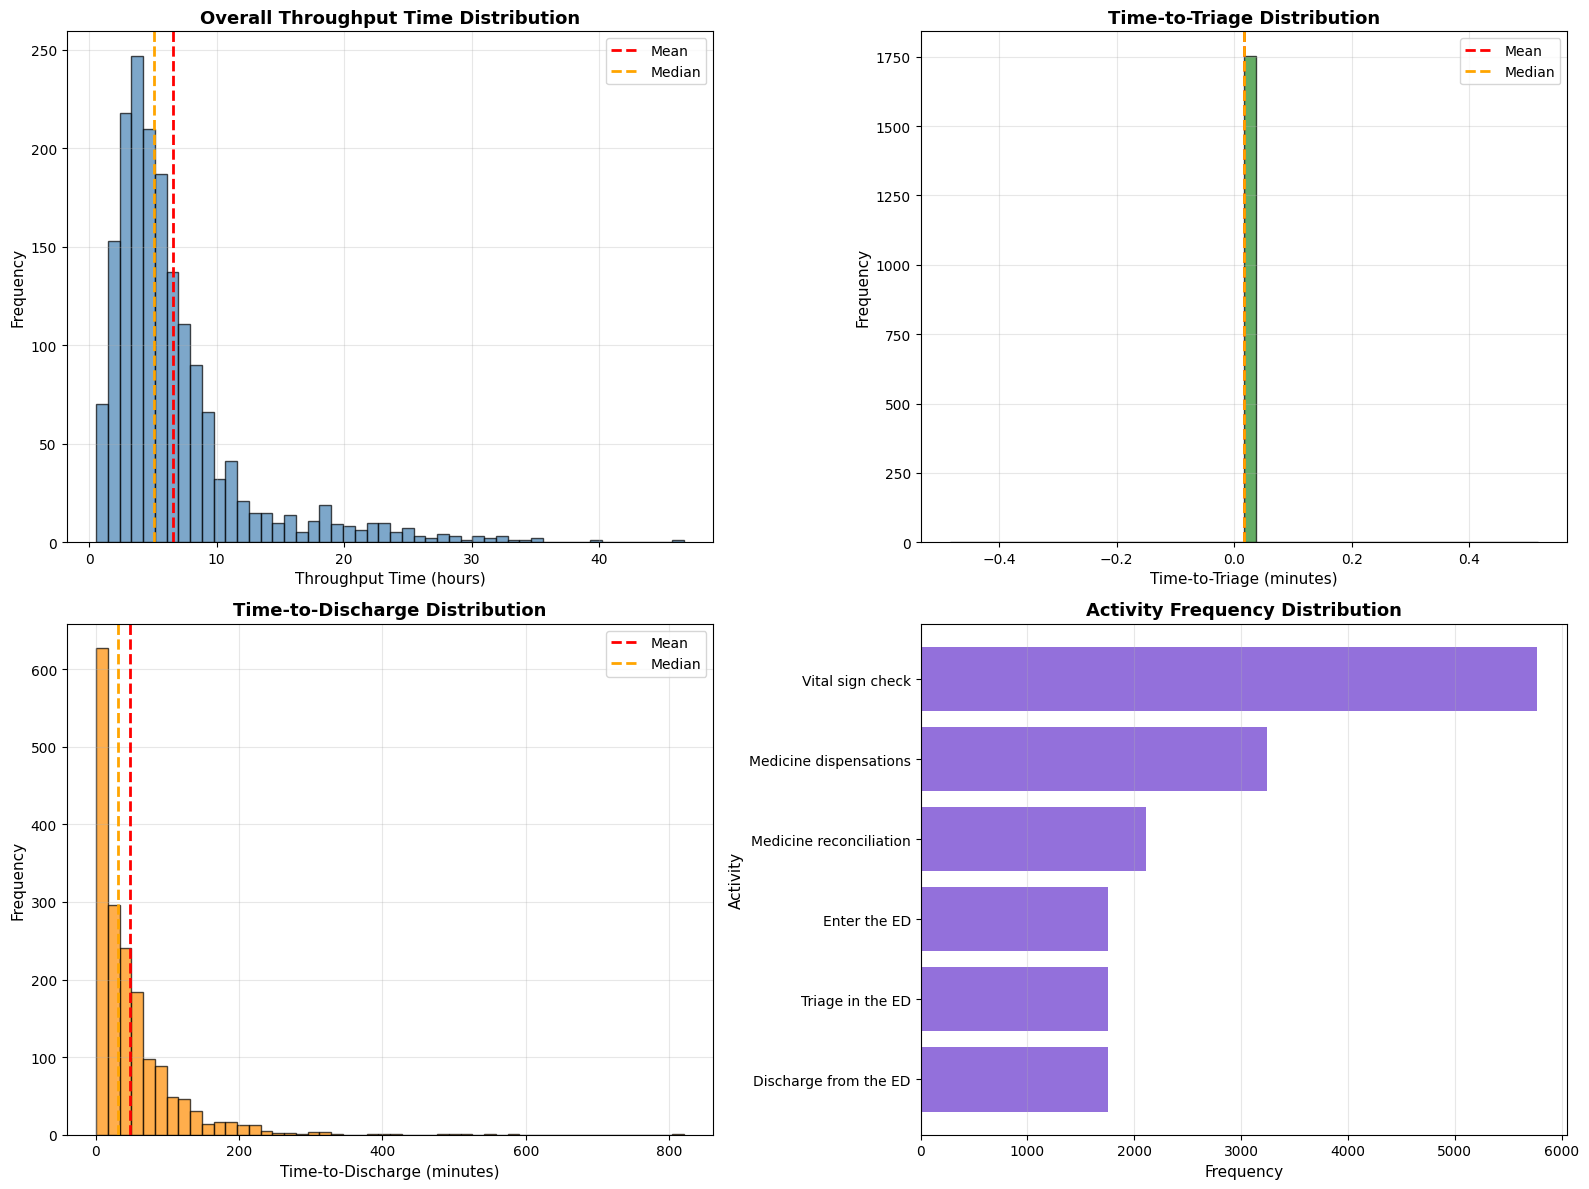

PERFORMANCE ANALYSIS SUMMARY

Total cases analyzed: 1754
Mean throughput time: 6.58 hours
Mean time-to-triage: 0.02 minutes
Mean time-to-discharge: 48.25 minutes
Number of unique variants: 884
Top variant covers: 4.3% of cases


In [54]:
#OVERALL VISUALIZATION

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Overall Throughput Time Distribution
axes[0, 0].hist(case_performance['throughput_time_hours'], bins=50, color='steelblue', edgecolor='black', alpha=0.7)
axes[0, 0].axvline(case_performance['throughput_time_hours'].mean(), color='red', linestyle='--', linewidth=2, label='Mean')
axes[0, 0].axvline(case_performance['throughput_time_hours'].median(), color='orange', linestyle='--', linewidth=2, label='Median')
axes[0, 0].set_xlabel('Throughput Time (hours)', fontsize=11)
axes[0, 0].set_ylabel('Frequency', fontsize=11)
axes[0, 0].set_title('Overall Throughput Time Distribution', fontsize=13, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Plot 2: Time-to-Triage Distribution
axes[0, 1].hist(time_to_triage['time_to_triage_minutes'], bins=50, color='forestgreen', edgecolor='black', alpha=0.7)
axes[0, 1].axvline(time_to_triage['time_to_triage_minutes'].mean(), color='red', linestyle='--', linewidth=2, label='Mean')
axes[0, 1].axvline(time_to_triage['time_to_triage_minutes'].median(), color='orange', linestyle='--', linewidth=2, label='Median')
axes[0, 1].set_xlabel('Time-to-Triage (minutes)', fontsize=11)
axes[0, 1].set_ylabel('Frequency', fontsize=11)
axes[0, 1].set_title('Time-to-Triage Distribution', fontsize=13, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# Plot 3: Time-to-Discharge Distribution
axes[1, 0].hist(time_to_discharge['time_to_discharge_minutes'], bins=50, color='darkorange', edgecolor='black', alpha=0.7)
axes[1, 0].axvline(time_to_discharge['time_to_discharge_minutes'].mean(), color='red', linestyle='--', linewidth=2, label='Mean')
axes[1, 0].axvline(time_to_discharge['time_to_discharge_minutes'].median(), color='orange', linestyle='--', linewidth=2, label='Median')
axes[1, 0].set_xlabel('Time-to-Discharge (minutes)', fontsize=11)
axes[1, 0].set_ylabel('Frequency', fontsize=11)
axes[1, 0].set_title('Time-to-Discharge Distribution', fontsize=13, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# Plot 4: Activity frequency
activity_counts = df['activity'].value_counts()
axes[1, 1].barh(activity_counts.index, activity_counts.values, color='mediumpurple')
axes[1, 1].set_xlabel('Frequency', fontsize=11)
axes[1, 1].set_ylabel('Activity', fontsize=11)
axes[1, 1].set_title('Activity Frequency Distribution', fontsize=13, fontweight='bold')
axes[1, 1].invert_yaxis()
axes[1, 1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print("PERFORMANCE ANALYSIS SUMMARY\n")
print(f"Total cases analyzed: {len(case_performance)}")
print(f"Mean throughput time: {case_performance['throughput_time_hours'].mean():.2f} hours")
print(f"Mean time-to-triage: {time_to_triage['time_to_triage_minutes'].mean():.2f} minutes")
print(f"Mean time-to-discharge: {time_to_discharge['time_to_discharge_minutes'].mean():.2f} minutes")
print(f"Number of unique variants: {len(variant_counts)}")
print(f"Top variant covers: {variant_counts.iloc[0]['percentage']:.1f}% of cases")


PROCESS DISCOVERY AND CONFORMANCE CHECKING
-------------------------

In [55]:
import pm4py
from pm4py.objects.conversion.log import converter as log_converter
from pm4py.objects.log.util import dataframe_utils

df_pm4py = df.copy()

#Rename columns to PM4Py standard format
df_pm4py = df_pm4py.rename(columns={
    'stay_id': 'case:concept:name',
    'activity': 'concept:name',
    'time': 'time:timestamp'
})

#Convert to PM4Py event log format
df_pm4py = dataframe_utils.convert_timestamp_columns_in_df(df_pm4py)
event_log = log_converter.apply(df_pm4py)

print("EVENT LOG CONVERSION\n")
print(f"Event log created successfully")
print(f"Number of traces (cases): {len(event_log)}")
print(f"Total events: {sum([len(trace) for trace in event_log])}")

# Verify log structure
print("\nSAMPLE TRACE")
sample_trace = event_log[0]
print(f"Case ID: {sample_trace.attributes['concept:name']}")
print(f"Number of events in trace: {len(sample_trace)}")
print("\nEvents:")
for event in sample_trace:
    print(f"  - {event['time:timestamp']} | {event['concept:name']}")


EVENT LOG CONVERSION

Event log created successfully
Number of traces (cases): 1754
Total events: 16376

SAMPLE TRACE
Case ID: 30005370
Number of events in trace: 10

Events:
  - 2110-06-25 05:10:00+00:00 | Enter the ED
  - 2110-06-25 05:10:01+00:00 | Triage in the ED
  - 2110-06-25 05:28:00+00:00 | Medicine reconciliation
  - 2110-06-25 05:29:00+00:00 | Medicine reconciliation
  - 2110-06-25 05:31:00+00:00 | Medicine dispensations
  - 2110-06-25 05:52:00+00:00 | Medicine dispensations
  - 2110-06-25 06:46:00+00:00 | Vital sign check
  - 2110-06-25 08:27:00+00:00 | Vital sign check
  - 2110-06-25 08:31:00+00:00 | Medicine dispensations
  - 2110-06-25 09:42:00+00:00 | Discharge from the ED


In [56]:
#INDUCTIVE MINER

from pm4py.algo.discovery.inductive import algorithm as inductive_miner
from pm4py.statistics.traces.generic.log import case_statistics
from pm4py.objects.conversion.process_tree import converter as pt_converter



#Discover Process Tree
process_tree = inductive_miner.apply(event_log)

print("Process Tree discovered")

#Convert Process Tree to Petri Net
net, initial_marking, final_marking = pt_converter.apply(process_tree)

print(f"\n Process model converted to Petri Net successfully")
print(f"   - Places (states): {len(net.places)}")
print(f"   - Transitions (activities): {len(net.transitions)}")
print(f"   - Arcs (connections): {len(net.arcs)}")

#Get trace statistics
variants = case_statistics.get_variant_statistics(event_log)
print(f"\n Process complexity:")
print(f"   - Unique variants in log: {len(variants)}")
print(f"   - Most common variant: {variants[0]['variant']} ({variants[0]['count']} cases)")

print("\n Model interpretation:")
print("   - Places represent states/conditions in the process")
print("   - Transitions represent activities")
print("   - The model shows the control-flow logic discovered from the log")


Process Tree discovered

 Process model converted to Petri Net successfully
   - Places (states): 15
   - Transitions (activities): 18
   - Arcs (connections): 40

 Process complexity:
   - Unique variants in log: 884
   - Most common variant: ('Enter the ED', 'Triage in the ED', 'Vital sign check', 'Discharge from the ED') (75 cases)

 Model interpretation:
   - Places represent states/conditions in the process
   - Transitions represent activities
   - The model shows the control-flow logic discovered from the log


PETRI NET VISUALIZATION



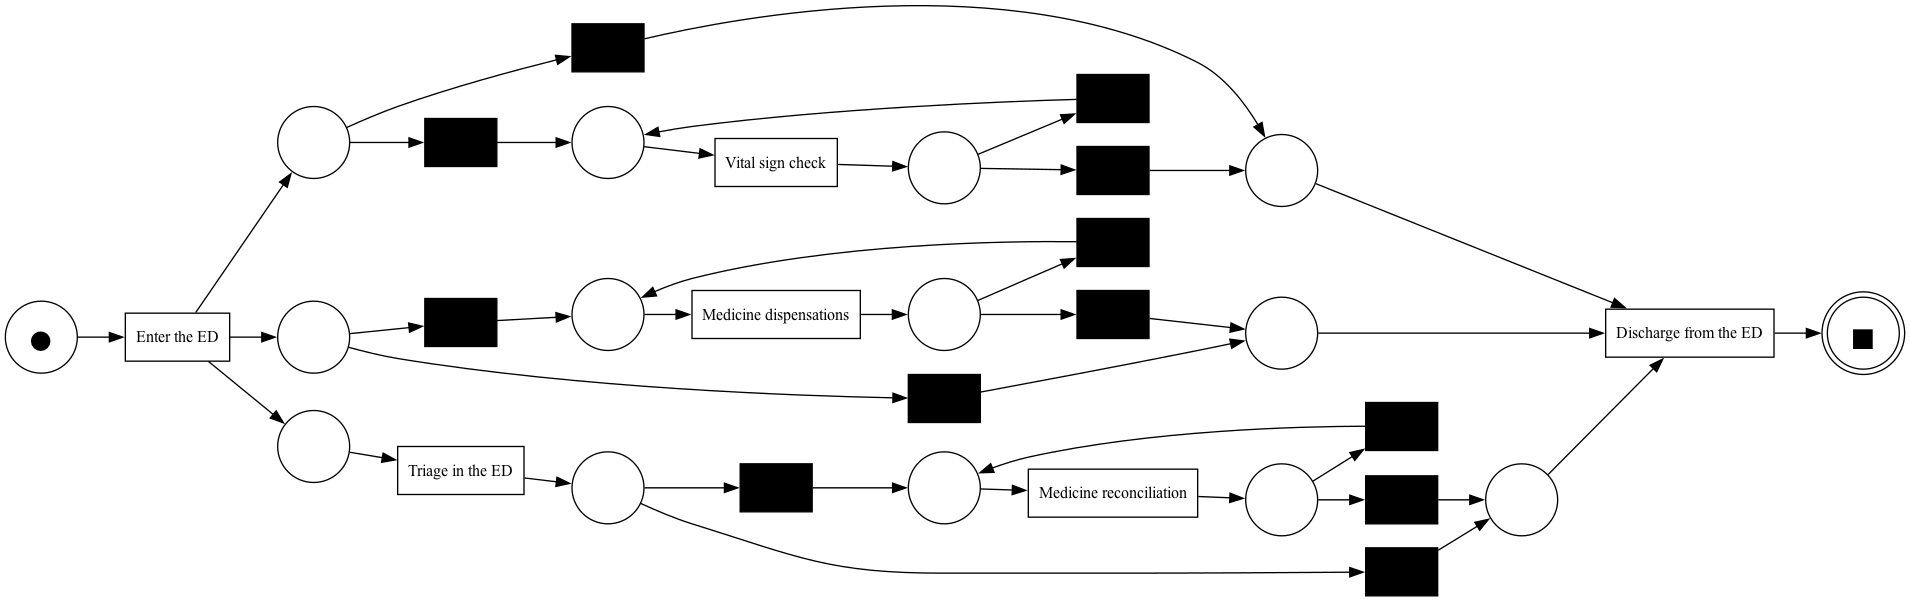


Petri Net Legend:
   - Circles (○) = Places (states/conditions)
   - Rectangles (▭) = Transitions (activities)
   - Arrows show the flow between activities
   - Initial marking (●) shows where cases start
   - Final marking shows where cases end


In [57]:
#VISUALIZE PETRI NET

from pm4py.visualization.petri_net import visualizer as pn_visualizer

#Visualize the discovered Petri Net
print("PETRI NET VISUALIZATION\n")

#Configure visualization parameters
parameters = {
    pn_visualizer.Variants.WO_DECORATION.value.Parameters.FORMAT: "png"
}

gviz = pn_visualizer.apply(
    net, 
    initial_marking, 
    final_marking,
    parameters=parameters
)

#Display the Petri Net
pn_visualizer.view(gviz)

print("\nPetri Net Legend:")
print("   - Circles (○) = Places (states/conditions)")
print("   - Rectangles (▭) = Transitions (activities)")
print("   - Arrows show the flow between activities")
print("   - Initial marking (●) shows where cases start")
print("   - Final marking shows where cases end")


DIRECTLY-FOLLOWS GRAPH (DFG)

Start activities:
   - Enter the ED: 1754 cases

End activities:
   - Discharge from the ED: 1754 cases


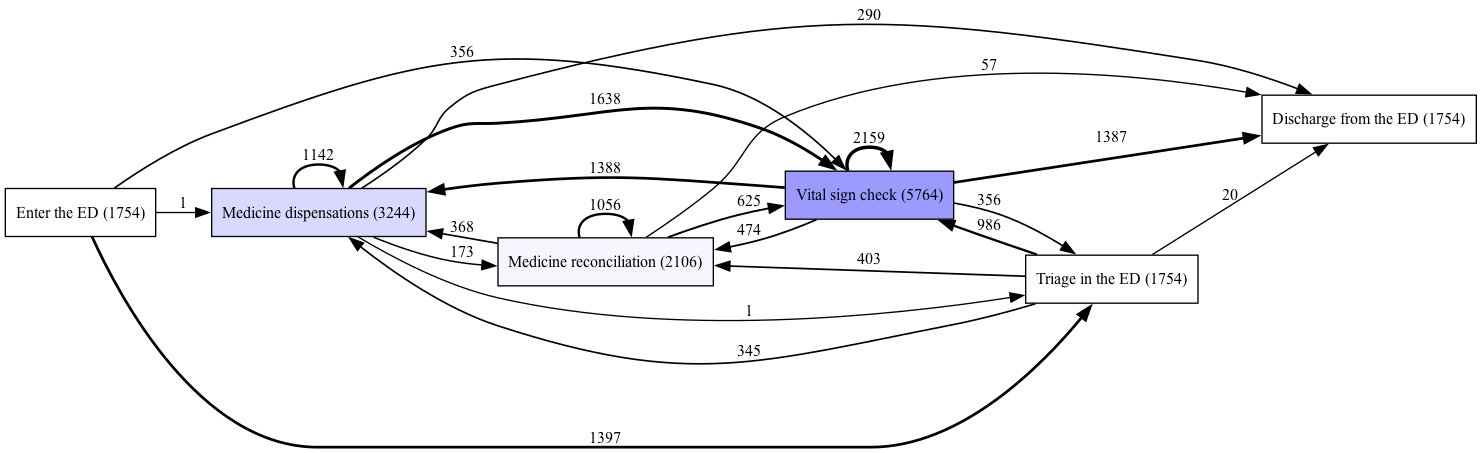

Frequency DFG generated (shows how often activities follow each other)


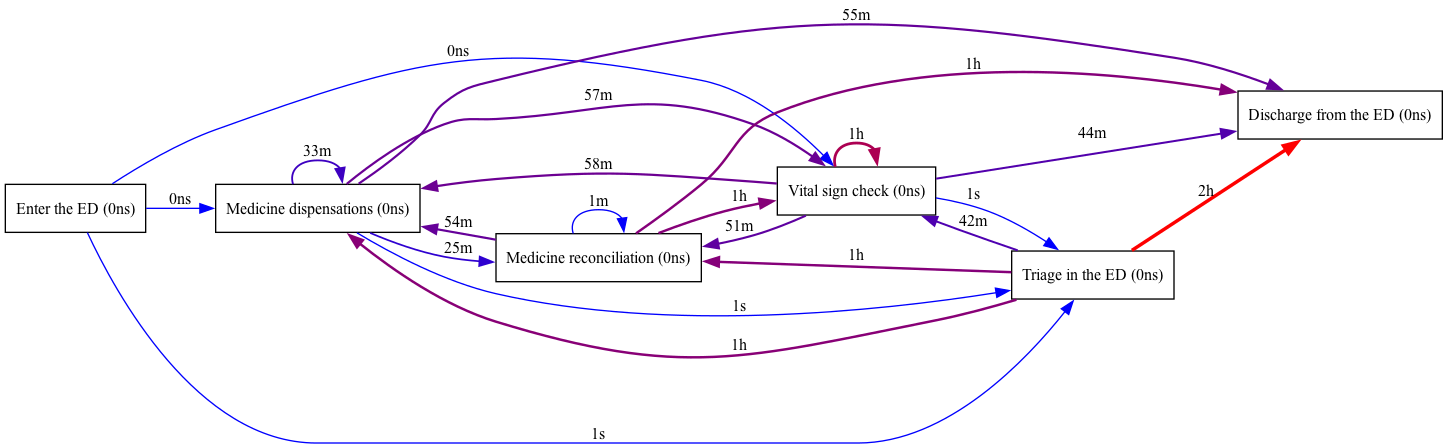

Performance DFG generated (shows average time between activities)


In [58]:
#DIRECTLY-FOLLOWS GRAPH (DFG)

from pm4py.algo.discovery.dfg import algorithm as dfg_discovery
from pm4py.visualization.dfg import visualizer as dfg_visualization

#Discover DFG (shows frequency and performance)
print("DIRECTLY-FOLLOWS GRAPH (DFG)\n")

#Get frequency-based DFG
dfg_freq = dfg_discovery.apply(event_log, variant=dfg_discovery.Variants.FREQUENCY)

#Get performance-based DFG (average time between activities)
dfg_perf = dfg_discovery.apply(event_log, variant=dfg_discovery.Variants.PERFORMANCE)

#Get start and end activities
from pm4py.statistics.start_activities.log import get as start_activities_get
from pm4py.statistics.end_activities.log import get as end_activities_get

start_activities = start_activities_get.get_start_activities(event_log)
end_activities = end_activities_get.get_end_activities(event_log)

print("Start activities:")
for act, count in start_activities.items():
    print(f"   - {act}: {count} cases")

print("\nEnd activities:")
for act, count in end_activities.items():
    print(f"   - {act}: {count} cases")

#Visualize frequency-based DFG
parameters_freq = {
    dfg_visualization.Variants.FREQUENCY.value.Parameters.FORMAT: "png"
}

gviz_freq = dfg_visualization.apply(
    dfg_freq,
    log=event_log,
    variant=dfg_visualization.Variants.FREQUENCY,
    parameters=parameters_freq
)

dfg_visualization.view(gviz_freq)
print("Frequency DFG generated (shows how often activities follow each other)")

# Visualize performance-based DFG
parameters_perf = {
    dfg_visualization.Variants.PERFORMANCE.value.Parameters.FORMAT: "png"
}

gviz_perf = dfg_visualization.apply(
    dfg_perf,
    log=event_log,
    variant=dfg_visualization.Variants.PERFORMANCE,
    parameters=parameters_perf
)

dfg_visualization.view(gviz_perf)
print("Performance DFG generated (shows average time between activities)")


In [61]:
#CONFORMANCE CHECKING

from pm4py.algo.conformance.tokenreplay import algorithm as token_replay
from pm4py.algo.evaluation.replay_fitness import algorithm as replay_fitness
from pm4py.algo.evaluation.precision import algorithm as precision_evaluator
from pm4py.algo.evaluation.generalization import algorithm as generalization_evaluator
from pm4py.algo.evaluation.simplicity import algorithm as simplicity_evaluator

print("CONFORMANCE CHECKING\n")

#Token-based replay (fitness)
print("Computing FITNESS")
replayed_traces = token_replay.apply(event_log, net, initial_marking, final_marking)

fitness = replay_fitness.evaluate(replayed_traces, variant=replay_fitness.Variants.TOKEN_BASED)
print(f"    Fitness: {fitness['log_fitness']:.4f}")
print(f"      (1.0 = perfect, all traces fit the model)")

#Precision
print("\nComputing PRECISION")
precision = precision_evaluator.apply(
    event_log, net, initial_marking, final_marking,
    variant=precision_evaluator.Variants.ETCONFORMANCE_TOKEN
)
print(f"    Precision: {precision:.4f}")
print(f"      (1.0 = perfect, model doesn't allow unseen behavior)")

#Generalization
print("\nComputing GENERALIZATION")
generalization = generalization_evaluator.apply(event_log, net, initial_marking, final_marking)
print(f"     Generalization: {generalization:.4f}")
print(f"      (Higher = model generalizes better to unseen cases)")

#Simplicity
print("\nComputing SIMPLICITY")
simplicity = simplicity_evaluator.apply(net)
print(f"     Simplicity: {simplicity:.4f}")
print(f"      (Higher = simpler model, easier to understand)")


print("\n" + "="*60)
print("CONFORMANCE SUMMARY")
print("="*60)
print(f"Fitness:         {fitness['log_fitness']:.4f}  {'✅' if fitness['log_fitness'] >= 0.95 else '⚠️'}")
print(f"Precision:       {precision:.4f}  {'✅' if precision >= 0.80 else '⚠️'}")
print(f"Generalization:  {generalization:.4f}")
print(f"Simplicity:      {simplicity:.4f}")
print("="*60)

print("\n💡 Interpretation:")
if fitness['log_fitness'] >= 0.95 and precision >= 0.80:
    print("   EXCELLENT: Model accurately represents the process")
elif fitness['log_fitness'] >= 0.90:
    print("   GOOD: Model represents most behaviors well")
elif fitness['log_fitness'] >= 0.80:
    print("   ACCEPTABLE: Some traces don't fit the model perfectly")
else:
    print("   POOR: Significant deviations between model and log")


CONFORMANCE CHECKING

Computing FITNESS


replaying log with TBR, completed traces :: 100%|██████████| 884/884 [00:00<00:00, 1620.97it/s]


    Fitness: 1.0000
      (1.0 = perfect, all traces fit the model)

Computing PRECISION


replaying log with TBR, completed traces :: 100%|██████████| 3724/3724 [00:04<00:00, 814.69it/s] 


    Precision: 0.7139
      (1.0 = perfect, model doesn't allow unseen behavior)

Computing GENERALIZATION


replaying log with TBR, completed traces :: 100%|██████████| 884/884 [00:00<00:00, 1677.34it/s]

     Generalization: 0.9694
      (Higher = model generalizes better to unseen cases)

Computing SIMPLICITY
     Simplicity: 0.7021
      (Higher = simpler model, easier to understand)

CONFORMANCE SUMMARY
Fitness:         1.0000  ✅
Precision:       0.7139  ⚠️
Generalization:  0.9694
Simplicity:      0.7021

💡 Interpretation:
   GOOD: Model represents most behaviors well


In [60]:
#IDENTIFY DEVIANT CASES

print("DEVIANT CASE ANALYSIS\n")

#Analyze token replay results to find non-conformant traces
conformant_traces = []
deviant_traces = []

for i, trace_result in enumerate(replayed_traces):
    trace = event_log[i]
    case_id = trace.attributes['concept:name']
    
    
    is_fit = (trace_result['missing_tokens'] == 0 and 
              trace_result['remaining_tokens'] == 0)
    
    trace_info = {
        'case_id': case_id,
        'n_events': len(trace),
        'missing_tokens': trace_result['missing_tokens'],
        'remaining_tokens': trace_result['remaining_tokens'],
        'consumed_tokens': trace_result['consumed_tokens'],
        'produced_tokens': trace_result['produced_tokens'],
        'is_fit': is_fit
    }
    
    if is_fit:
        conformant_traces.append(trace_info)
    else:
        deviant_traces.append(trace_info)

#stats
print(f"Total traces analyzed: {len(event_log)}")
print(f"Conformant traces: {len(conformant_traces)} ({len(conformant_traces)/len(event_log)*100:.1f}%)")
print(f"Deviant traces: {len(deviant_traces)} ({len(deviant_traces)/len(event_log)*100:.1f}%)")

if len(deviant_traces) > 0:
    print("\n Top 10 most deviant cases:")
    deviant_df = pd.DataFrame(deviant_traces)
    deviant_df['total_tokens_issue'] = (deviant_df['missing_tokens'] + 
                                         deviant_df['remaining_tokens'])
    deviant_df = deviant_df.sort_values('total_tokens_issue', ascending=False)
    
    print(deviant_df.head(10)[['case_id', 'n_events', 'missing_tokens', 
                                 'remaining_tokens', 'total_tokens_issue']].to_string(index=False))
    
    print("\n Analysis:")
    print(f"   - Missing tokens indicate the trace performed activities not allowed by the model")
    print(f"   - Remaining tokens indicate the trace ended prematurely")
    
    #Get variant of most deviant case
    most_deviant_case_id = deviant_df.iloc[0]['case_id']
    most_deviant_trace = [t for t in event_log if t.attributes['concept:name'] == most_deviant_case_id][0]
    
    print(f"\n Most deviant case ({most_deviant_case_id}):")
    print("   Activity sequence:")
    for event in most_deviant_trace:
        print(f"      → {event['concept:name']}")
else:
    print("\nAll traces are perfectly conformant to the model!")


DEVIANT CASE ANALYSIS

Total traces analyzed: 1754
Conformant traces: 1754 (100.0%)
Deviant traces: 0 (0.0%)

All traces are perfectly conformant to the model!
